# Fig Setup
Using chou 20210504 unsort data Ch53. <br>
shortcaption: Distribution of $\{STS\}$. <br>
label: STdistr

In [1]:
XOsave = True

# Function

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import cm
from matplotlib import animation, rc
from IPython.display import HTML
from scipy import ndimage
from scipy.io import loadmat
import seaborn as sns
import pandas as pd
import os
%matplotlib inline

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["mathtext.fontset"] = "cm"

In [3]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
    
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from StimulusnResponse import expSnR

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb


## ST-collection

In [4]:
def STcollection(r, x, v, dt, window):
    negshift = round(window[0]/dt) # second
    posshift = round(window[1]/dt) # second
    xcoll = np.zeros(posshift-negshift)
    vcoll = np.zeros(posshift-negshift)
    for i in np.arange(-negshift, len(r)-posshift):
        conter = r[i]
        while conter != 0:
            xcoll = np.vstack((xcoll , x[i+negshift:i+posshift]))
            vcoll = np.vstack((vcoll , v[i+negshift:i+posshift]))
            conter -= 1
    time = np.arange(negshift*dt, posshift*dt, dt)
    return time, xcoll[1:], vcoll[1:]

# Main

In [5]:
Fc_list = [2]
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2' for Fc in Fc_list]

dt = 0.01
cn = 53
x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [cn])
x = x_list[0]
T = T_list[0]
rstate = rstate_list[0][cn-1,:]
cutoffFreq = Fc_list[0]/2

In [6]:
v = ndimage.gaussian_filter1d(x, order=1, sigma=1)/dt
v = (v-np.mean(v)) / np.std(v)

state_num = 6
xstate = EqualState(x, state_num)[0]
vstate = EqualState(v, state_num)[0]

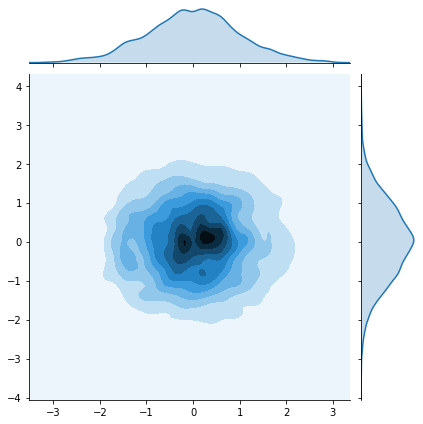

In [7]:
sns.jointplot(x,v, kind="kde")

In [8]:
#calculate STA
window = [-1,1] # second
time, xcoll, vcoll = STcollection(rstate, x, v, dt, window)
xSTA = np.mean(xcoll, axis=0)
vSTA = np.mean(vcoll, axis=0)
xSTstd = np.std(xcoll, axis=0)
vSTstd = np.std(vcoll, axis=0)

In [9]:
window = [-1,1] # second
timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)

# Video Section

(-2.5, 2.5)

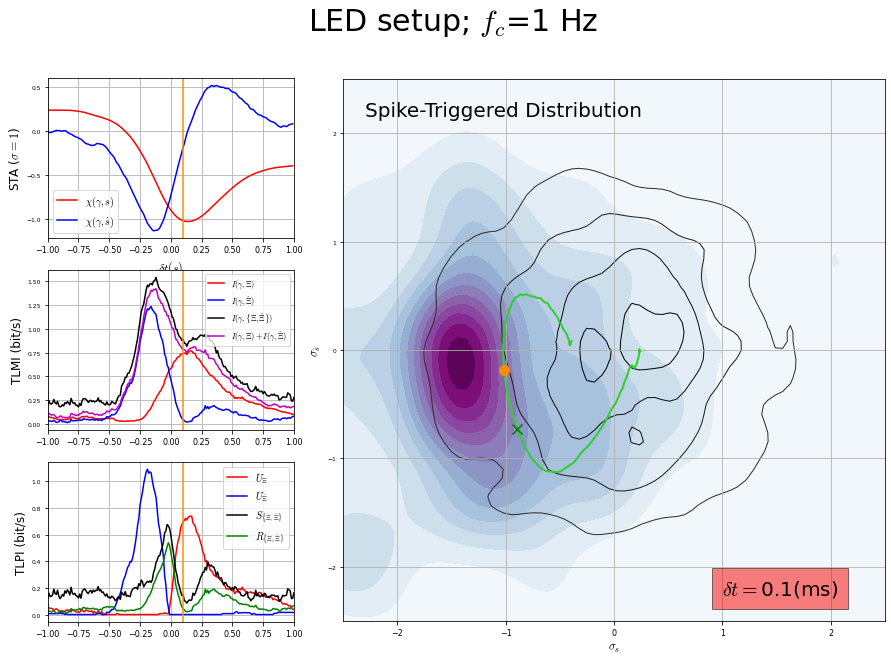

In [13]:
moving_object = []
index = 110

plt.rcParams["font.size"] = 12
plt.rcParams['xtick.labelsize'] =  8
plt.rcParams['ytick.labelsize'] =  6

fig = plt.figure()
fig.set_size_inches(15, 10)
fig.suptitle(r'LED setup; $f_c$=1 Hz', fontsize = 30)
ax3 = fig.add_subplot(3, 3, 1)
ax2 = fig.add_subplot(3, 3, 4)
ax5 = fig.add_subplot(3, 3, 7)
ax4 = fig.add_subplot(1, 3, (2,5))

MIx = Information[('Beer','UIx')]+Information[('Beer','Red')]
MIv = Information[('Beer','UIv')]+Information[('Beer','Red')]
MIjoint = Information[('Beer','UIx')]+Information[('Beer','Syn')]+Information[('Beer','UIv')]+Information[('Beer','Red')]
#MI
ax2.plot(timeshift,MIx, 'r-')
ax2.plot(timeshift,MIv, 'b-')
ax2.plot(timeshift,MIjoint, 'k-')
ax2.plot(timeshift,MIx+MIv, 'm-')
ax2.set_ylabel('TLMI (bit/s)')
ax2.legend( (r'$I(\gamma,\Xi)$', r'$I(\gamma,\dot\Xi)$', r'$I(\gamma,\{\Xi,\dot\Xi\})$', r'$I(\gamma,\Xi)+I(\gamma,\dot\Xi)$')
           , loc='upper right', fontsize=8)
#PI
ax5.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax5.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax5.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax5.plot(timeshift,Information[('Beer','Red')], 'g-')
ax5.set_ylabel('TLPI (bit/s)')
ax5.legend( (r'$U_\Xi$', r'$U_{\dot\Xi}$', r'$S_{ \{\Xi,\dot\Xi\} }$', r'$R_{ \{\Xi,\dot\Xi\} }$'), loc='best', fontsize=10)
#STA & STstd
ax3.plot(time,xSTA,'r-')
ax3.plot(time,vSTA, 'b-')
ax3.set_xlabel(r'$\delta t(s)$')
ax3.set_ylabel(r'STA ($\sigma = 1$)')
ax3.legend( (r'$\chi(\gamma, s)$', r'$\chi(\gamma, \dot s)$'), loc='best', fontsize=10)

for ax in (ax5,ax2,ax3):
    ax.grid(True)
    ax.set_xlim([-1,1])
    moving_object.append( ax.axvline( time[index], c='darkorange', linewidth = 1.5) )#Moving

    
## Distribution of STS
plt.rcParams["font.size"] = 18
plt.rcParams['xtick.labelsize'] =  10
plt.rcParams['ytick.labelsize'] =  10
moving_object.append( sns.kdeplot(xcoll[:,index],vcoll[:,index], ax = ax4, shade=True, cmap=cm.BuPu, levels=15, zorder=0) ) #Moving
BaseC = sns.kdeplot(x,v, ax = ax4, colors=cm.Greys(np.linspace(0.8,1,5)), linewidths=1, levels=5, zorder=1)

ax4.plot(xSTA,vSTA, linewidth=2,color = 'limegreen', zorder=11)
moving_object.append( ax4.scatter(xSTA[index],vSTA[index], c='darkorange', s=  100, zorder=13) )#Moving
ax4.scatter(xSTA[int(len(time)/2+0.5)],vSTA[int(len(time)/2+0.5)], c='green', marker='x', s=  100, zorder=12)
ax4.set_xlabel(r'$\sigma_s$')
ax4.set_ylabel(r'$\sigma_{\dot s}$')
moving_object.append( ax4.text(1, -2.3, r'$\delta t=$'+str(np.round(time[index],3))+'(ms)', fontsize=20,
                      ha = 'left', va='bottom', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10}) ) #Moving
ax4.text(-2.3, 2.3, 'Spike-Triggered Distribution', ha = 'left', va='top', fontsize=20)
ax4.set_aspect('equal', 'box')
ax4.grid(True, zorder=100)
ax4.set_xlim([-2.5,2.5])
ax4.set_ylim([-2.5,2.5])

In [11]:
def animate(i):
    moving_object[0].set_xdata(time[i])
    moving_object[1].set_xdata(time[i])
    moving_object[2].set_xdata(time[i])
    moving_object[3] = sns.kdeplot(xcoll[:,i],vcoll[:,i], ax = ax4, shade=True, cmap=cm.BuPu, levels=15, zorder=0)
    moving_object[4].set_offsets(np.c_[xSTA[i], vSTA[i]])
    moving_object[5].set_text(r'$\delta t=$'+str(np.round(time[i],3))+'(ms)')
    return (moving_object,)

anim = animation.FuncAnimation(fig, animate, frames=len(time), interval=40)

In [12]:
# HTML(anim.to_html5_video())

In [14]:
if XOsave:
    anim.save('D:\\GoogleDrive\\retina\\thesis\\fig\\STdistr.mp4', writer='ffmpeg', fps=30, dpi = 300)